***

# <font color=red>Bank Graph Example Notebook</font>
<p style="margin-left:10%; margin-right:10%;">by the <font color=teal>by Rahul Tasker</font></p>

***

Oracle Data Science service sample notebook.

Copyright (c) 2021, 2022 Oracle, Inc. All rights reserved. Licensed under the [Universal Permissive License v 1.0](https://oss.oracle.com/licenses/upl).



# Overview:

This notebook shows how we can access graphs in an autonomous database instance. We can then run algorithms on and query the graph. From the result set, we can transform the result set using common datascience tools like pandas, and pyplot.

Compatible conda pack: [Parallel Graph AnalytiX 23.1 and Oracle Property Graph 23.1 for CPU on Python 3.8](https://docs.oracle.com/en-us/iaas/data-science/using/conda-database-fam.htm) for CPU on Python 3.8 (version 1.0)

---

## Step 1: Import required libraries
This can also be done at any point in the notebook, but for simplicity, we can import all necessary libraries at the start to use them throughout the rest of the notebook.

In [1]:
from opg4py.adb import AdbClient
import pandas
import matplotlib.pyplot as plt

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/home/datascience/conda/pypgx2310_p38_cpu_v1/lib/python3.8/site-packages/pypgx/jars/log4j-slf4j-impl-2.17.1.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/home/datascience/conda/pypgx2310_p38_cpu_v1/lib/python3.8/site-packages/opg4py/jars/logback-classic-1.2.10.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.apache.logging.slf4j.Log4jLoggerFactory]


## Step 2: Connect to ADB
The following four paragraphs create the config for an Autonomous Database connection, creates a client connection, checks if the graph client is attached, starts the Graph Studio environment, and checks what user started the job creation job for Graph Studio. 
<br/><br/>
Here, we assume that you have created a BANK_GRAPH in Graph Studio. If you have not, you can launch an ADB environment with this [reference architecture](https://docs.oracle.com/en/solutions/oci-adb-graph-analytics/index.html), and find instructions to create the property graph [here](https://docs.oracle.com/en/cloud/paas/autonomous-database/csgru/create-graph-existing-relational-tables.html). 

In [2]:
config = {
          'tenancy_ocid': '<tenancy_ocid>',
          'database': '<autonomous_database_name>',
          'database_ocid': '<autonomous_database_ocid>',
          'username': 'GRAPH_USER',
          'password': '<graphuser_password>',
          'endpoint': 'https://<hostname-prefix>.adb.<region>.oraclecloudapps.com/'
 }

client = AdbClient(config)
client.__enter__()

In [3]:
client.is_attached()

False

In [4]:
# If the environment is already started, the line below will throw a "IllegalStateException: environment currently attached" error.
# If so, skip this paragraph
job = client.start_environment(10)
job.get()
job.get_name()

'Compute Environment Creation - 16.0 GBs'

In [5]:
job.get_created_by()

'GRAPH_USER'

## Step 3: Create PGX Session and Load Bank Graph into Memory

The next paragraph creates a pgx session. The paragraph after checks if the Bank Graph is already loaded into memory, if it is not, it is loaded.

In [6]:
instance = client.get_pgx_instance()
session = instance.create_session("adb-session")

In [7]:
GRAPH_NAME="BANK_GRAPH";
# try getting the graph from the in-memory graph server
graph = session.get_graph(GRAPH_NAME);
# if it does not exist read it into memory
if (graph == None) :
    session.read_graph_by_name(GRAPH_NAME, "pg_view")
    print("Graph "+ GRAPH_NAME + " successfully loaded")
    graph = session.get_graph(GRAPH_NAME);
else :
    print("Graph '"+ GRAPH_NAME + "' already loaded");

Graph BANK_GRAPH successfully loaded


## Step 4: Run PageRank Algorithm

Pagerank measures the importance of each node within the graph, based on the number incoming relationships and the importance of the corresponding source nodes

In [8]:
analyst = session.create_analyst()
analyst.pagerank(graph)

VertexProperty(name: pagerank, type: double, graph: BANK_GRAPH)

## Step 5: Query Graph

In [9]:
rs = graph.execute_pgql("SELECT a.acct_id, a.pagerank FROM MATCH (a) ON bank_graph ORDER BY acct_id asc")
rs.print()

+---------------------------------+
| acct_id | pagerank              |
+---------------------------------+
| 1       | 3.368007271998356E-4  |
| 2       | 0.0010063470268767848 |
| 3       | 7.01888320478737E-4   |
| 4       | 2.8964564425667096E-4 |
| 5       | 7.085952144251868E-4  |
| 6       | 8.535673179236218E-4  |
| 7       | 3.730142789310487E-4  |
| 8       | 4.8397117244350666E-4 |
| 9       | 6.28417079901585E-4   |
| 10      | 3.52715942314313E-4   |
| 11      | 4.060413230099527E-4  |
| 12      | 4.703554787267831E-4  |
| 13      | 4.4945118962088726E-4 |
| 14      | 7.499664348490245E-4  |
| 15      | 4.679544314901538E-4  |
| 16      | 3.5911370031031716E-4 |
| 17      | 2.951926159026123E-4  |
| 18      | 6.999077025611332E-4  |
| 19      | 3.089217795664357E-4  |
| 20      | 9.99872617588508E-4   |
| 21      | 4.63201937848608E-4   |
| 22      | 8.476460373983662E-4  |
| 23      | 0.0010059785417325738 |
| 24      | 4.0954523960724565E-4 |
| 25      | 3.59483335471663

## Step 6: Convert to Pandas Dataframe 

In [10]:
result_df = rs.to_pandas()
print(result_df)

     acct_id  pagerank
0          1  0.000337
1          2  0.001006
2          3  0.000702
3          4  0.000290
4          5  0.000709
..       ...       ...
995      996  0.000333
996      997  0.000301
997      998  0.000709
998      999  0.000335
999     1000  0.000359

[1000 rows x 2 columns]


In [11]:
# get basic statistics for the numerical columns of a Pandas DataFrame
result_df.describe()

acct_id     pagerank
count  1000.000000  1000.000000
mean    500.500000     0.000505
std     288.819436     0.000192
min       1.000000     0.000217
25%     250.750000     0.000370
50%     500.500000     0.000449
75%     750.250000     0.000596
max    1000.000000     0.001703

In [12]:
# Calculate the standard deviation of the given set of numbers, DataFrame, column, and rows
result_df.std()

acct_id     288.819436
pagerank      0.000192
dtype: float64

## Step 7: Create Visualization Charts

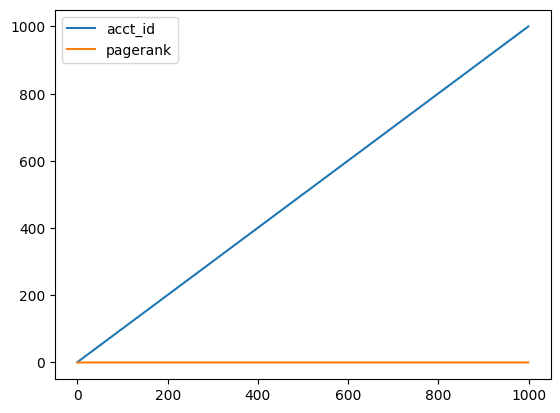

In [13]:
result_df.plot()
plt.show()

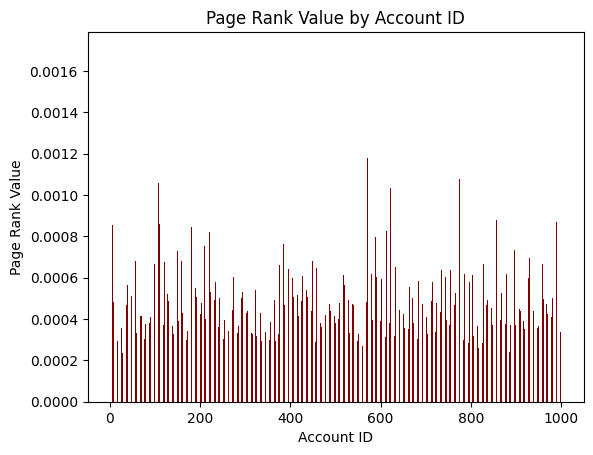

In [14]:
rs_df = graph.execute_pgql("SELECT a.acct_id, a.pagerank FROM MATCH (a) ON bank_graph").to_pandas()
df = rs_df.sort_values(by='acct_id', ascending=False)
accounts = df['acct_id']
values = df['pagerank']
plt.bar(accounts, values, color ='maroon', width = 0.4)
plt.xlabel("Account ID")
plt.ylabel("Page Rank Value")
plt.title("Page Rank Value by Account ID")
plt.show()

## Step 8: Close PGX Session

In [15]:
# Close the session after executing all graph queries
session.close()